# How can a Government Improve their Nation's Overall Happiness?

## Introduction

### Importance
Happiness is the only quality of our lives which ultimately matters. It's how we passively quantify all the factors we deem important in living a good life, i.e. it's the overall appreciation of one's life as a whole. Would one rather be rich and powerful yet unhappy or neither rich nor powerful yet happy? Money does bring some happiness, but there is an extent. 

A Government is a non profit organization that is to the people, for the people, by the people. It aims to work for the people and their betterment as a whole. Thus, one of the best values to judge a country's success is by how happy their citizens are. 

### Goals
*The main goal of this notebook is to determine what any given government should first improve upon if they were interested in increasing the average happiness of their citizens. This means providing the features that will give the largest immidiate improvement in happiness. I will give examples using the created model on Kenya, a third world country, and the United States, a first world country, to determine which potential (both immediate and longer term) improvements they would benefit most from.*

### Data
The core of the data being used comes from the World Happiness Report of 2018, which encompasses data from most countries spanning 2005-2017. The data itself was acquired by the Gallup World Poll, which I sadly do not have access to as it requires an ever so slightly steep annual fee of $30,000.

In the dataset happiness is measured as a ladder, the question asked of people surveyed was: “Please imagine a ladder, with steps numbered from 0 at the bottom to 10 at the top. The top of the ladder represents the best possible life for you and the bottom of the ladder represents the worst possible life for you. On which step of the ladder would you say you personally feel you stand at this time?”

Along with the Life Ladder feature, features from the perception of an individual's Government to Social Support are included within the same dataset. However, the dataset is still fairly limited and doesn't seem to contain most of the factors a government plays in happiness, so I'll need to merge this data with other various datasets.

**Features pertaining to the goal, for reference:**

1. Age dependency ratio - Age-population ratio of those in labor force and those not
2. Birth rate
3. Confidence in national government
4. Death rate
5. Delivery quality - Government Effectiveness, Regulatory Quality, Rule of Law, Control of Corruption
6. Democratic quality - Voice and Accountability, Political Stability and Absence of Violence
7. Freedom to make life choices - “Are you satisfied with your freedom to choose what you do with your life?”
8. GDP per capita
9. Gender inequality Index - a composite measure of gender inequality using three dimensions: reproductive health, empowerment and the labour market. A value closer to 0 means higher equality.
10. GINI Household income - Income inequality (0 if everyone had same income, 1 if one person had all income)
11. Health expenditure (\% of govt.) - percentage of govt. spending on health care
12. Life expectancy
13. Life ladder
14. Negative affect - "Worry, sadness and anger."
15. Perceptions of corruption - "Is corruption widespread through your government or not?"
16. Positive affect - "Happiness, laugh and enjoyment."
17. School enrollment, tertiary - Enrollment percentage in higher education

### Basic Imports

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd

In [2]:
### Creating a class to suppress output (specifically for imputing with Matrix Factorization) ###
import os, sys
import warnings

class HiddenOutput:
    def __enter__(self):
        self._original_stdout = sys.stdout
        sys.stdout = open(os.devnull, 'w')

    def __exit__(self, exc_type, exc_val, exc_tb):
        sys.stdout.close()
        sys.stdout = self._original_stdout

## Data Cleaning
I have collected 4 different datasets on countries, already having removed all features unnecessary for this project - with the aim to keep the ones which will capture as much of the life ladder rating as possible. Too many features also runs the risk of more missing data.

First thing to do is reformat the datasets to match each other before they are joined. <br>
We want each other dataset to match that of the happiness dataset. 

So we are going from this:
<pre>
   Country        Feature           2005    2006    2007    2008    2009

0  Afghanistan    Age Dependency    99.0    99.5    100.0   100.2   100.1
1  Afghanistan    Birth Rate        44.9    43.9    42.8    41.6    40.3
2  Afghanistan    Death Rate        10.7    10.4    10.1    9.8     9.5
3  Albania        Age Dependency    53.5    52.2    50.9    49.7    48.7
4  Albania        Birth Rate        12.3    11.9    11.6    11.5    11.6
5  Albania        Death Rate        5.95    6.13    6.32    6.51    6.68

</pre>
to this:
<pre>

                       Age Dependency    Birth Rate    Death Rate

Afghanistan    2005    99.0              44.9          10.7
               2006    99.5              43.9          10.4
               2007    100.0             42.8          10.1   
               2008    100.2             41.6          9.8
               2009    100.1             40.3          9.5

Albania        2005    53.5              12.3          5.95
               2006    52.2              11.9          6.13
               2007    50.9              11.6          6.32
               2008    49.7              11.5          6.51
               2009    48.7              11.6          6.68
</pre>
<br>
Which requires creating columns out of the repeating Feature values and indices out of the year columns.

In [3]:
# The core happiness dataset
happiness_df = pd.read_csv("datasets/Happiness_2018.csv").rename(columns={'country':'Country', 'year': 'Year'})
happiness_df = happiness_df.drop(columns=['GINI index (World Bank estimate)', 
                                          'GINI index (World Bank estimate), average 2000-15', # Both missing too much data
                                          'Healthy life expectancy at birth', # Redundant
                                          'Positive affect',
                                          'Negative affect', # Too similar to Life Ladder
                                          'Generosity', # Amount donated, mostly attributed to GDP and culture
                                          'Social support']) # Although a big factor, has greatly to do with family
happiness_df = happiness_df.set_index(['Country', 'Year'])

# Country dataset with 6 features
country_df = pd.read_csv("datasets/Country_Data_Clean.csv").rename(columns={'Country Name':'Country'})
country_df = country_df.drop(columns=['Country Code', 'Indicator Code'])
country_df = country_df.melt(['Country', 'Indicator Name'], var_name='Year')\
                  .set_index(['Country', 'Year', 'Indicator Name'])['value']\
                  .unstack()

# Gender inequality dataset judged by reproductive health, empowerment, and labour market
inequality_df = pd.read_csv('datasets/gender_inequality_index.csv')
inequality_df = inequality_df.drop(columns=['HDI Rank (2015)'])
inequality_df = inequality_df.melt(['Country'], var_name='Year', value_name='HDI Inequality')\
            .sort_values(['Country', 'Year']).set_index(['Country', 'Year'])

# Population density per square kilometer
pop_df = pd.read_csv('datasets/Population_density.csv').rename(columns={'Country Name':'Country'})
pop_df = pop_df.drop(columns=['Indicator Code', 'Country Code'])
pop_df = pop_df.melt(['Country', 'Indicator Name'], var_name='Year')\
                  .set_index(['Country', 'Year', 'Indicator Name'])['value']\
                  .unstack()

Now that each dataset is correctly formatted, we have to match the year columns to all be int so joining is possible.

In [4]:
inequality_df = inequality_df.reset_index()
inequality_df['Year'] = inequality_df['Year'].astype(int)
inequality_df = inequality_df.set_index(['Country', 'Year'])

country_df = country_df.reset_index()
country_df['Year'] = country_df['Year'].astype(int)
country_df = country_df.set_index(['Country', 'Year'])

pop_df = inequality_df.reset_index()
pop_df['Year'] = pop_df['Year'].astype(int)
pop_df = pop_df.set_index(['Country', 'Year'])

Here we join to get the entire dataset with every feature we want.

In [5]:
df = happiness_df.join(inequality_df).join(country_df).join(pop_df, how='left', lsuffix='_left', rsuffix='_right')
df.drop(columns=['HDI Inequality_right'], inplace=True)
df.rename(columns={'HDI Inequality_left':'HDI Inequality'}, inplace=True)
df

Life Ladder  Log GDP per capita  \
Country     Year                                    
Afghanistan 2008     3.723590            7.168690   
            2009     4.401778            7.333790   
            2010     4.758381            7.386629   
            2011     3.831719            7.415019   
            2012     3.782938            7.517126   
            2013     3.572100            7.503376   
            2014     3.130896            7.484583   
            2015     3.982855            7.466215   
            2016     4.220169            7.461401   
            2017     2.661718            7.460144   
Albania     2007     4.634252            9.077325   
            2009     5.485470            9.161633   
            2010     5.268937            9.203026   
            2011     5.867422            9.230898   
            2012     5.510124            9.246649   
            2013     4.550648            9.258439   
            2014     4.813763            9.278097   
            2015     4.606651            9.303031   
            2016     4.511101            9.337774   
            2017     4.639548            9.373718   
Algeria     2010     5.463567            9.462701   
            2011     5.317194            9.471962   
            2012     5.604596            9.485086   
            2014     6.354898            9.509210   
            2016     5.340854            9.541166   
            2017     5.248912            9.540244   
Angola      2011     5.589001            8.684613   
            2012     4.360250            8.699287   
            2013     3.937107            8.729884   
            2014     3.794838            8.741957   
...                       ...                 ...   
Yemen       2011     3.746256            8.244134   
            2012     4.060601            8.241021   
            2013     4.217679            8.261730   
            2014     3.967958            8.233983   
            2015     2.982674            7.878930   
            2016     3.825631            7.751505   
            2017     3.253560                 NaN   
Zambia      2006     4.824455            7.866006   
            2007     3.998293            7.918941   
            2008     4.730263            7.966175   
            2009     5.260361            8.026193   
            2011     4.999114            8.120028   
            2012     5.013375            8.163204   
            2013     5.243996            8.182191   
            2014     4.345837            8.197678   
            2015     4.843164            8.196217   
            2016     4.347544            8.201650   
            2017     3.932777            8.211670   
Zimbabwe    2006     3.826268            7.366704   
            2007     3.280247            7.313939   
            2008     3.174264            7.102516   
            2009     4.055914            7.197595   
            2010     4.681570            7.296330   
            2011     4.845642            7.418864   
            2012     4.955101            7.534424   
            2013     4.690188            7.565154   
            2014     4.184451            7.562753   
            2015     3.703191            7.556052   
            2016     3.735400            7.538829   
            2017     3.638300            7.538187   

                  Freedom to make life choices  Perceptions of corruption  \
Country     Year                                                            
Afghanistan 2008                      0.718114                   0.881686   
            2009                      0.678896                   0.850035   
            2010                      0.600127                   0.706766   
            2011                      0.495901                   0.731109   
            2012                      0.530935                   0.775620   
            2013                      0.577955                   0.823204   
            2014                      0.508514                

In [6]:
# Num entries and num non-null values
df.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 1562 entries, (Afghanistan, 2008) to (Zimbabwe, 2017)
Data columns (total 15 columns):
Life Ladder                                                 1562 non-null float64
Log GDP per capita                                          1535 non-null float64
Freedom to make life choices                                1533 non-null float64
Perceptions of corruption                                   1472 non-null float64
Confidence in national government                           1401 non-null float64
Democratic Quality                                          1391 non-null float64
Delivery Quality                                            1391 non-null float64
gini of household income reported in Gallup, by wp5-year    1205 non-null float64
HDI Inequality                                              754 non-null float64
Age dependency ratio (% of working-age population)          1229 non-null float64
Birth rate, crude (per 1,000 people)        

1. Notice that there are many dispersed missing values, we will fill these based on the mean of other values from the same country and column, as these values should be very close to one another. Values barely change year over year.
2. There are features some countries have no data on. In this case it's best to impute using Matrix Factorization to match the best guess as to what a certain piece of missing data would be.

In [7]:
# (1)
df = df.groupby(['Country']).transform(lambda x: x.fillna(x.mean()))

# (2)
from fancyimpute import MatrixFactorization
with warnings.catch_warnings(): # Ignore deprecation warnings
    warnings.simplefilter("ignore")
    with HiddenOutput():
        df.iloc[:,:] = MatrixFactorization().fit_transform(df.iloc[:,:]);

Using TensorFlow backend.


In [8]:
df.isna().sum()

Life Ladder                                                 0
Log GDP per capita                                          0
Freedom to make life choices                                0
Perceptions of corruption                                   0
Confidence in national government                           0
Democratic Quality                                          0
Delivery Quality                                            0
gini of household income reported in Gallup, by wp5-year    0
HDI Inequality                                              0
Age dependency ratio (% of working-age population)          0
Birth rate, crude (per 1,000 people)                        0
Death rate, crude (per 1,000 people)                        0
Health expenditure, public (% of government expenditure)    0
Life expectancy at birth, total (years)                     0
School enrollment, tertiary (% gross)                       0
dtype: int64

There aren't anymore null values left so we now have the final dataset

In [9]:
df

Life Ladder  Log GDP per capita  \
Country     Year                                    
Afghanistan 2008     3.723590            7.168690   
            2009     4.401778            7.333790   
            2010     4.758381            7.386629   
            2011     3.831719            7.415019   
            2012     3.782938            7.517126   
            2013     3.572100            7.503376   
            2014     3.130896            7.484583   
            2015     3.982855            7.466215   
            2016     4.220169            7.461401   
            2017     2.661718            7.460144   
Albania     2007     4.634252            9.077325   
            2009     5.485470            9.161633   
            2010     5.268937            9.203026   
            2011     5.867422            9.230898   
            2012     5.510124            9.246649   
            2013     4.550648            9.258439   
            2014     4.813763            9.278097   
            2015     4.606651            9.303031   
            2016     4.511101            9.337774   
            2017     4.639548            9.373718   
Algeria     2010     5.463567            9.462701   
            2011     5.317194            9.471962   
            2012     5.604596            9.485086   
            2014     6.354898            9.509210   
            2016     5.340854            9.541166   
            2017     5.248912            9.540244   
Angola      2011     5.589001            8.684613   
            2012     4.360250            8.699287   
            2013     3.937107            8.729884   
            2014     3.794838            8.741957   
...                       ...                 ...   
Yemen       2011     3.746256            8.244134   
            2012     4.060601            8.241021   
            2013     4.217679            8.261730   
            2014     3.967958            8.233983   
            2015     2.982674            7.878930   
            2016     3.825631            7.751505   
            2017     3.253560            8.191046   
Zambia      2006     4.824455            7.866006   
            2007     3.998293            7.918941   
            2008     4.730263            7.966175   
            2009     5.260361            8.026193   
            2011     4.999114            8.120028   
            2012     5.013375            8.163204   
            2013     5.243996            8.182191   
            2014     4.345837            8.197678   
            2015     4.843164            8.196217   
            2016     4.347544            8.201650   
            2017     3.932777            8.211670   
Zimbabwe    2006     3.826268            7.366704   
            2007     3.280247            7.313939   
            2008     3.174264            7.102516   
            2009     4.055914            7.197595   
            2010     4.681570            7.296330   
            2011     4.845642            7.418864   
            2012     4.955101            7.534424   
            2013     4.690188            7.565154   
            2014     4.184451            7.562753   
            2015     3.703191            7.556052   
            2016     3.735400            7.538829   
            2017     3.638300            7.538187   

                  Freedom to make life choices  Perceptions of corruption  \
Country     Year                                                            
Afghanistan 2008                      0.718114                   0.881686   
            2009                      0.678896                   0.850035   
            2010                      0.600127                   0.706766   
            2011                      0.495901                   0.731109   
            2012                      0.530935                   0.775620   
            2013                      0.577955                   0.823204   
            2014                      0.508514                

## Data Analysis and Visualization

Choosing some interesting features, let's first see how and if they correlate with Life Ladder

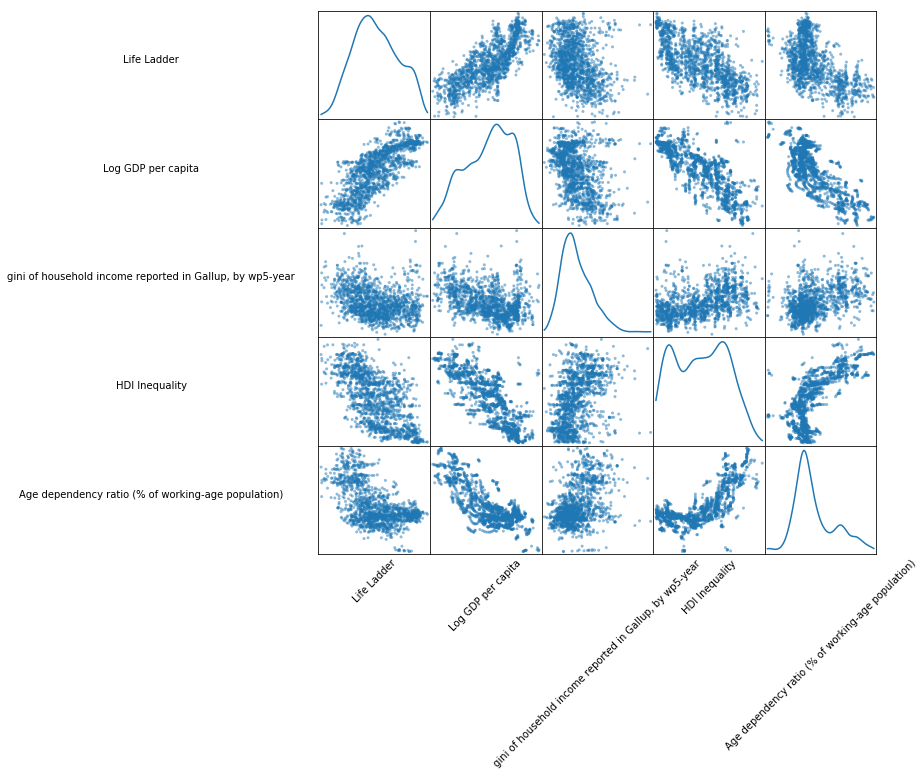

In [10]:
with HiddenOutput():
    sm = pd.plotting.scatter_matrix(df[['Life Ladder', 'Log GDP per capita', 
                               'gini of household income reported in Gallup, by wp5-year', 'HDI Inequality',
                              'Age dependency ratio (% of working-age population)']], figsize=(10, 10), diagonal='kde')
    
    # Rotate labels so they don't overlap
    [s.xaxis.label.set_rotation(45) for s in sm.reshape(-1)]
    [s.yaxis.label.set_rotation(0) for s in sm.reshape(-1)]
    
    # Prevent labels from overlapping plots
    [s.get_yaxis().set_label_coords(-1.5,0.5) for s in sm.reshape(-1)]
    
    # Hide ticks
    [s.set_xticks(()) for s in sm.reshape(-1)]
    [s.set_yticks(()) for s in sm.reshape(-1)]

The most noticeable things:
1. It looks like most of these features do in fact correlate well, however, household income inequality doesn't seem too promising. 
2. The correlation of features with Life Ladder look very similar to the correlation of features with GDP.

In [11]:
# (1) Checking correlation coefficient R of household income inequality
df['Life Ladder'].corr(df['gini of household income reported in Gallup, by wp5-year'])

-0.2999552145429449

There is in fact a weak downward trend associated to how satisfied a person is with their life as the nation's income inequality increases. Additionally, it looks like the income inequality has a greater affect on happiness past a certain mark. This means having up to a certain amount of income inequality makes no significant difference.

Let's get F-test p-values and use simple linear regression to see some coefficients and get a feel for which single qualities are generally important for a government to provide.

In [12]:
y = np.array(df['Life Ladder'])
X = np.array(df.iloc[:, 1:])

In [13]:
from sklearn.feature_selection import f_regression
from sklearn import linear_model

# F-test p-values
F, p = f_regression(X, y)

# Multilinear regression coefficients
clf = linear_model.LinearRegression()
clf.fit(X, y)

corr = pd.DataFrame(clf.coef_.reshape(1, -1), columns=list(df.columns[1:])).transpose() \
                    .rename(columns={0 : 'coef'}).sort_values(['coef'], ascending=False)

corr.join(pd.DataFrame(p.reshape(1, -1), columns=list(df.columns[1:])).transpose() \
            .rename(columns={0 : 'p-value'}).sort_values(['p-value'], ascending=False))

,coef,p-value
Freedom to make life choices,1.810974,1.224220e-108
Log GDP per capita,0.470480,2.542244e-318
Democratic Quality,0.072329,2.050645e-162
"Health expenditure, public (% of government expenditure)",0.043820,3.045213e-76
"Birth rate, crude (per 1,000 people)",0.011829,6.798102e-172
"School enrollment, tertiary (% gross)",0.005635,3.449504e-184
Age dependency ratio (% of working-age population),0.001984,3.811170e-125
"Life expectancy at birth, total (years)",0.001254,8.316533e-264
"Death rate, crude (per 1,000 people)",-0.054489,1.960501e-35
Delivery Quality,-0.072053,1.007463e-240


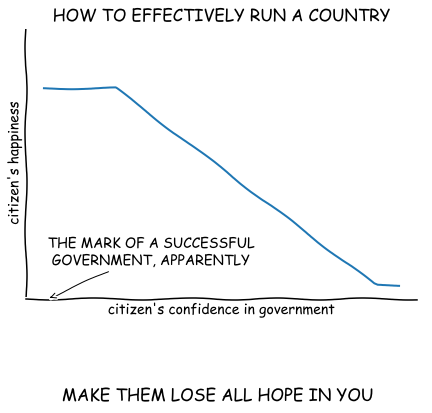

In [14]:
plt.xkcd()
# The mark of a succesful Government, apparently
fig, ax = plt.subplots(figsize=(7,5))
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
plt.xticks([])
plt.yticks([])
ax.set_ylim([-30, 10])

data = np.ones(100)
data[20:93] -= (np.arange(73) / 2.5)
data[93:100] = -28

plt.annotate(
    'THE MARK OF A SUCCESSFUL\n GOVERNMENT, APPARENTLY',
    xy=(1, -30), arrowprops=dict(arrowstyle='->'), xytext=(1, -25))

plt.annotate(
    'MAKE THEM LOSE ALL HOPE IN YOU',
    xy=(70, 1), xytext=(5, -45), fontsize=17)

plt.plot(data)

plt.xlabel('citizen\'s confidence in government')
plt.ylabel('citizen\'s happiness')

plt.title('HOW TO EFFECTIVELY RUN A COUNTRY')

plt.show()

Joking aside, even though an increase in confidence of the national government does negatively affect happiness in multilinear regression, it has no correlation with Life Ladder directly... and it's not very useful, nor does it make sense giving advice to lower people's confidence in their government if you want them to be happier.

In [15]:
print(df['Life Ladder'].corr(df['Confidence in national government']))
df = df.drop(columns=['Confidence in national government']);

-0.07038231879310633


**Anyway,** *back to the multilinear coefficients:* <br>
- Freedom to make life choices, or whether or not an individual feels satisfied that they are able to choose what they do with their life, is at the top. A goverment could approach this in multiple ways; from providing people more opportunities such as free college tuition to increased civil rights for all people.
<br><br>
- The GINI of household income describes the country's income inequality and is one of the biggest factors contributing to a decreased average happiness. A country struggling with wealth imbalance should focus on a better distribution of wealth.

Now let's chart the happiness using the 6 most distinguishing features given by the linear regression coefficients. I will min-max scale each feature and then take their percentage worth of each country's Life Ladder value. This way we can see the make up of a country's happiness based on how each of their features compare to other countries.

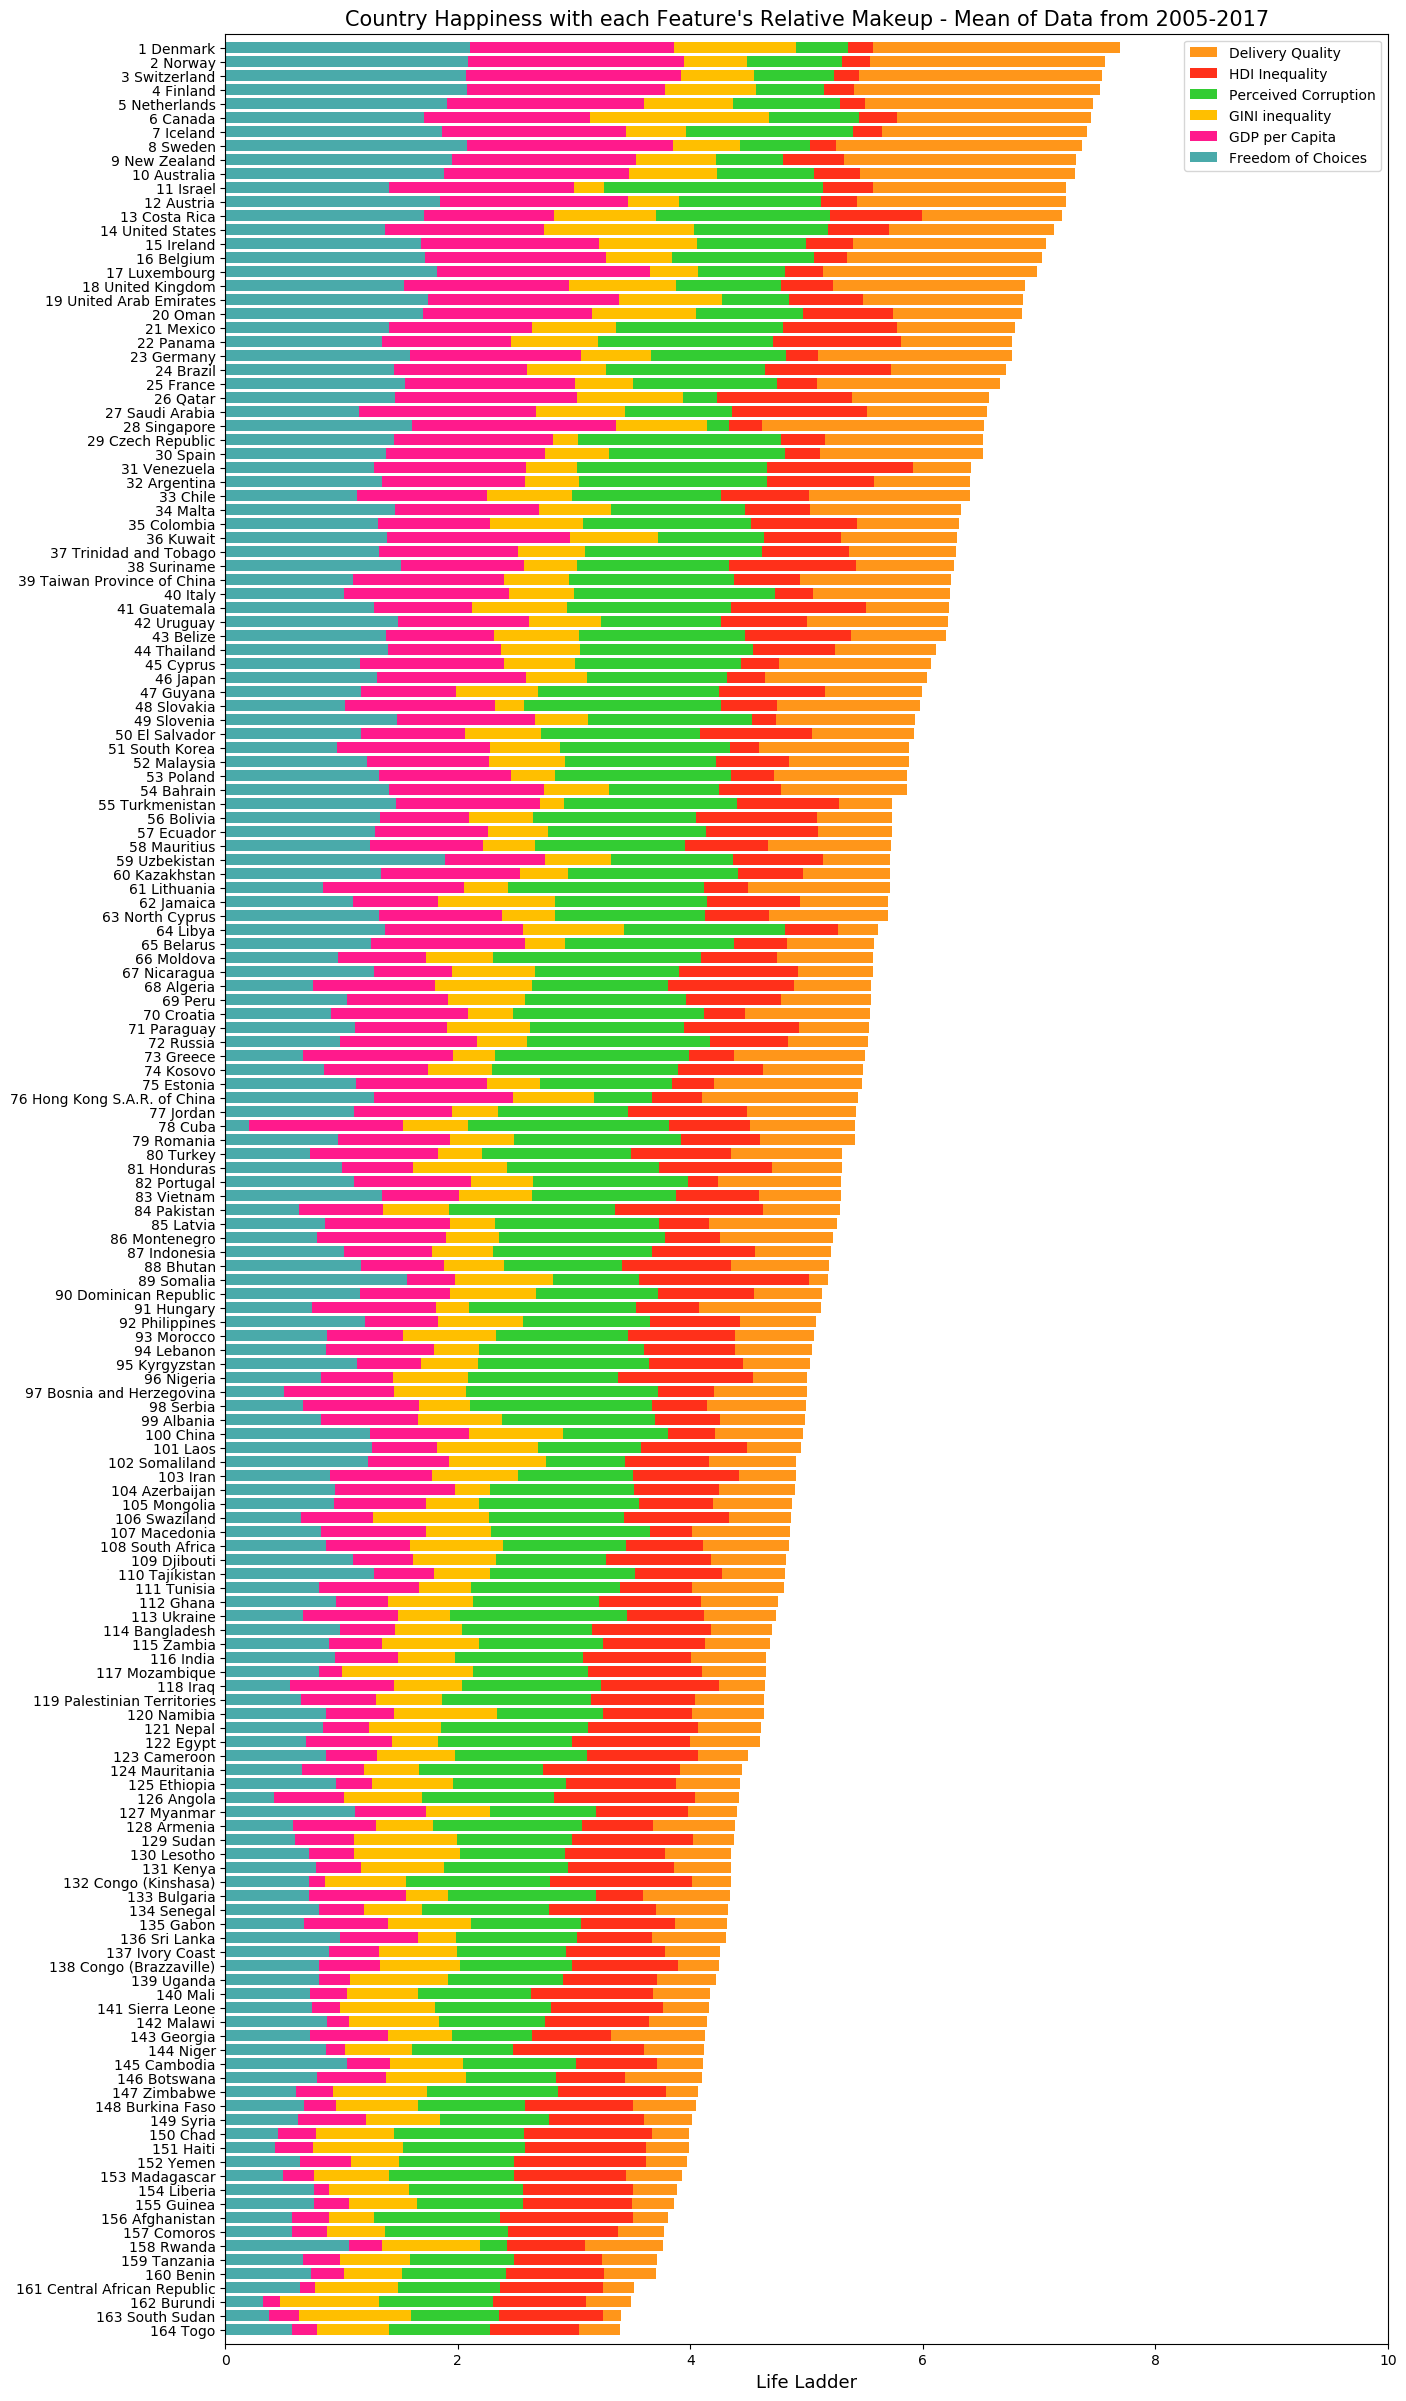

In [46]:
plt.rcdefaults()
fig, ax = plt.subplots(figsize=(15,30))

# Use the most significant variables
ranks = df[['Life Ladder', 'Freedom to make life choices', 'Log GDP per capita',
           'gini of household income reported in Gallup, by wp5-year', 'Perceptions of corruption',
            'HDI Inequality', 'Delivery Quality']].groupby(['Country']).mean().sort_values(by='Life Ladder', 
                                                                                               ascending=False)

# Scale each feature value (except for y) between 0.1 and 1 by column
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range=(0.1, 1)).fit(ranks.iloc[:, 1:])
ranks.iloc[:, 1:] = sc.transform(ranks.iloc[:, 1:])

# Multiply percentage of each value by Life Ladder, cumulative sum for stacked bar chart
totals = ranks.iloc[:, 1:].sum(axis=1)
ranks.iloc[:, 1:] = ranks.iloc[:, 1:].divide(totals, axis=0).multiply(ranks['Life Ladder'], axis=0).cumsum(axis=1)

# Plot each feature
y_pos = np.arange(len(ranks))
p1=plt.barh(y_pos, ranks['Delivery Quality'].get_values(), color='#FF961A')
p2=plt.barh(y_pos, ranks['HDI Inequality'].get_values(), color = '#FF301A')
p3=plt.barh(y_pos, ranks['Perceptions of corruption'].get_values(), color='#33cc33')
p4=plt.barh(y_pos, ranks['gini of household income reported in Gallup, by wp5-year'].get_values(), color='#ffbf00')
p5=plt.barh(y_pos, ranks['Log GDP per capita'].get_values(), color='#ff1a8c')
p6=plt.barh(y_pos, ranks['Freedom to make life choices'].get_values(), color='#4AAAAA')

y_indices = np.array(ranks.index)
labels = np.append(np.arange(1, y_indices.shape[0] + 1).reshape(-1, 1), y_indices.reshape(-1, 1), axis=1)
labels = [str(row[0]) + ' ' + row[1] for row in labels]

ax.set_yticks(y_pos)
ax.set_yticklabels(labels)
ax.invert_yaxis()
ax.set_xlabel('Life Ladder', fontsize=13)
ax.set_title('Country Happiness with each Feature\'s Relative Makeup - Mean of Data from 2005-2017', 
            fontsize=15)
plt.ylim(len(ranks) , -1)
plt.xlim(0, 10)
plt.legend((p1[0], p2[0], p3[0], p4[0], p5[0], p6[0]), ('Delivery Quality', 'HDI Inequality', 'Perceived Corruption', 
                                                        'GINI inequality', 'GDP per Capita', 
                                                        'Freedom of Choices'))
plt.show()

As expected, many of the features that contribute to a greater life ladder shrink in percentage of makeup, and the features that hurt the life ladder increase in percentage as the ranking decreases.

## Supervised Learning

### Fitting the Model using an SVM

In [48]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import ShuffleSplit

X = np.array(df.iloc[:, 1:])
y = np.array(df['Life Ladder'])
scaler = StandardScaler().fit(X)
stand_X = scaler.transform(X)

train_X, test_X, train_y, test_y = train_test_split(stand_X, y, train_size=0.7, 
                                                    test_size=0.3, shuffle=True)

cv = ShuffleSplit(n_splits=100, test_size=0.2)
param_grid = {'C' : np.logspace(-3, 2, 6), 'gamma': np.logspace(-3, 2, 6)}

svr = SVR(kernel='rbf')
grid = GridSearchCV(svr, param_grid=param_grid, cv=cv, return_train_score=True)

grid.fit(train_X, train_y)

GridSearchCV(cv=ShuffleSplit(n_splits=100, random_state=None, test_size=0.2, train_size=None),
       error_score='raise-deprecating',
       estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1,
  gamma='auto_deprecated', kernel='rbf', max_iter=-1, shrinking=True,
  tol=0.001, verbose=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02]), 'gamma': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [49]:
grid.best_params_

{'C': 10.0, 'gamma': 0.1}

In [50]:
print('Train score:', grid.score(train_X, train_y))
print('Test score:', grid.score(test_X, test_y))

Train score: 0.9440438247948686
Test score: 0.8812209651052747


**Check for underfitting/overfitting now that we have the chosen parameters**

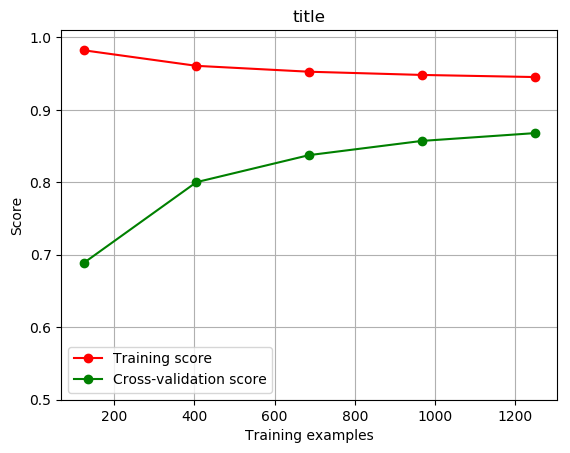

In [51]:
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit

plt.rcdefaults()
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    plt.grid()

    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

cv = ShuffleSplit(n_splits=100, test_size=0.2)
plot_learning_curve(SVR(kernel='rbf', C=10, gamma=0.1),
                    'title', stand_X, y, (0.5, 1.01), cv=cv, n_jobs=4)
plt.show()

There is a small gap between the CV and training scores, meaning more data would be useful, but since there is no way of getting more data outside of waiting for years - this is fine. There isn't much overfitting happening anyway.

## Finding a country's features that need to be improved

Here I am going to create a simple function which will determine what any certain government needs to work on foremost with the goal of improving happiness. I'm sure finding the gradient at a point would work with some models, but I decided to use an 'rbf' kernel SVM. So instead to make things simpler I'm, simply put, checking the greatest change in score of each feature, updating that feature, and then checking the next greatest change in score.

In [52]:
def improve_which_features(X, tot_increase=4, step=0.1):
    '''
    Principal function for this notebook.
    Get the best features to improve when sent parameters of a country.
    
    Parameters
    ----------
    X : length 13
        Must be scaled before sent
    
    tot_increase: Number total Standard deviations to increase data by
    
    step: Amount each feature is increased by to compare  
    '''
    
    better_X = np.copy(X)
    num_features = X.shape[0]
    
    # Increment each feature by 0.01 200 times to check which one increases the score the most each increment
    scores = np.zeros(num_features)
    additional_increase = 0
    order = np.array([])
    for i in np.arange(0, 4, 0.1):
        increase = 0
        best_feature = -1
        
        for j in range(num_features):
            temp_X_plus = np.copy(better_X)
            temp_X_plus[j] += (.01 + additional_increase)
            temp_X_minus = np.copy(better_X)
            temp_X_minus[j] -= (.01 + additional_increase)
            
            first = float(grid.predict(temp_X_plus.reshape(1, -1)))
            second = float(grid.predict(temp_X_minus.reshape(1, -1)))

            new_happ = np.maximum(first, second)
            temp_increase = new_happ - float(grid.predict(better_X.reshape(1, -1)))
            
            # Limit the increase to 1 SD. Potential to create unrealistic goals otherwise
            if np.greater(temp_increase, increase) and scores[j] < 2:
                increase = temp_increase
                best_feature = j
                
        if best_feature != -1:
            scores[best_feature] += .1 + additional_increase
            better_X[best_feature] += .1 + additional_increase
            additional_increase = 0
            order = np.append(order, np.array([best_feature]))
        else:
            additional_increase += .01
            
    return order, scores

Let's use the function on two countries: Kenya and the United States: <br>
- Kenya is a third world country but is well placed to transition to a first world country. Obviously this transition is a big factor in improving happiness - first world countries clearly have much higher happiness rankings on average. Perhaps it could be easier to reach such a position by focusing on the happiness, then. <br><br>
- United States is a first world country but has dropped far in their happiness ranking. All the way from 3rd in 2007 to 18th last year in 2017. It would be interesting to see what could help bring them back. 

Here are the column indices, for reference

In [53]:
pd.DataFrame(np.linspace(0, 12, 13, dtype=int).reshape(1, -1), columns=list(df.columns[1:])).transpose() \
                    .rename(columns={0 : 'Index'})

,Index
Log GDP per capita,0
Freedom to make life choices,1
Perceptions of corruption,2
Democratic Quality,3
Delivery Quality,4
"gini of household income reported in Gallup, by wp5-year",5
HDI Inequality,6
Age dependency ratio (% of working-age population),7
"Birth rate, crude (per 1,000 people)",8
"Death rate, crude (per 1,000 people)",9


In [54]:
# Kenya (2017)
order, scores = improve_which_features(scaler.transform(np.array( \
                                       df.loc[['Country', 'Kenya']])[11, 1:].reshape(1, -1))[0])
print('Order of largest increase in scores:\n', order)
print('\nTotal scores:\nFeature:   0  1   2   3    4  5   6   7   8   9   10  11  12', '\n  Score:', scores)

Order of largest increase in scores:
 [ 4.  4.  4.  4.  4.  4.  4.  4.  4.  4.  4.  4.  4.  4.  4.  4.  4.  4.
  4.  4.  9.  9.  9.  9. 11. 11. 11. 11. 11. 11. 11. 11. 11. 11. 11. 11.
 11. 11. 11. 11.]

Total scores:
Feature:   0  1   2   3    4  5   6   7   8   9   10  11  12 
  Score: [0.  0.  0.  0.  2.  0.  0.  0.  0.  0.4 0.  1.6 0. ]


For Kenya, it looks like Delivery quality is the first important feature to improve upon for Kenya. Delivery quality was judged on government effectiveness, regulatory quality, rule of law, control of corruption. This means that a focus on the workings of the government and making sure it runs well may be essential for Kenya to break into the first world. After delivery quality is improved it will be important for them to improve on lowering their death rate and increasing life expectancy, which go hand-in-hand. This could be accomplished by a focus on sanitation and an increase of doctors and healthcare available.

In [55]:
# United States (2017)
order, scores = improve_which_features(scaler.transform(np.array( \
                                       df.loc[['Country', 'United States']])[11, 1:].reshape(1, -1))[0])
print('Order of largest increase in scores:\n', order)
print('\nTotal scores:\nFeature:   0  1    2  3   4   5   6   7   8   9   10  11  12', '\n  Score:', scores)

Order of largest increase in scores:
 [ 8.  4.  8.  4.  8. 12. 12. 12. 12. 12. 12. 12. 12. 12. 12. 12. 12. 12.
 12. 12. 12. 12. 12. 12. 12.  4.  2.  4.  3.  3.  3.  3.  3.  3.  3.  3.
  3.  3.  3.  3.]

Total scores:
Feature:   0  1    2  3   4   5   6   7   8   9   10  11  12 
  Score: [0.  0.  0.1 1.2 0.4 0.  0.  0.  0.3 0.  0.  0.  2. ]


These results show that a slight increase in birth rate and delivery quality could help. More importantly, though, is an increase in tertiary school enrollment (universities and trade school) and democratic quality (Voice and Accountability, Political Stability and Absence of Violence), in that respective order - from the list of features we have access to at least. Higher education could be increased through government funding, since that is one of the main factors keeping potential sutdents away. The factors of democratic quality we have problems with are pretty apparent in the United States too.

This solution is far from perfect, more features and data would be very useful, but I hope this shows you some of my knowledge! The concepts in this notebook could even be applied to something along the lines of customer service.  